# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : Explainability with eli5


---

# Initialisations
---

In [1]:
_rs = 42

In [2]:
cd ../..

/Volumes/Geek/Work/Patat


In [3]:
import ast
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

# Préparation Données

---

## Chargements

In [4]:
import patat.util.file

filename = 'data/tmp/230603-df_ml.pickle'

df_ml = patat.util.file.pickle_load(filename)

In [5]:
stopwords = patat.util.file.pickle_load('data/tmp/stopwords.pickle')

# eli5 Text Explainer
---

## Preprocessing

In [6]:
import patat.util.text

In [7]:
import re

In [8]:
def preprocess(text):
    text = patat.util.text.preprocess(text)
    # Remove numbers
    text = re.sub(r'\d+','',text)
    return text

In [9]:
df_ml['text_p']=df_ml['text'].apply(preprocess)

## Reduction du nombre de paragraphes

In [10]:
nb_parags = 13
def cut_text(text):
    return '\n'.join(text.split('\n')[:nb_parags])

In [11]:
df_ml['text_ml']=df_ml['text_p'].apply(cut_text)

## Entrainement pipeline sur l'ensemble du corpus

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline

In [97]:
#classifier = LogisticRegression(C=150, random_state=_rs, solver='lbfgs', multi_class='ovr', max_iter=1000)
#classifier = LogisticRegression(C=150, random_state=_rs, max_iter=1000)
classifier = MLPClassifier()

In [98]:
sw = stopwords[:120]
#sw = stopwords

In [99]:
#vectorizer = TfidfVectorizer(stop_words=sw,ngram_range=(2,3))
vectorizer = TfidfVectorizer(stop_words=sw)

In [100]:
pipe = make_pipeline(vectorizer, classifier)

In [101]:
X = df_ml['text']
y = df_ml['infox']

## Crossvalidation

In [102]:
scores = cross_validate(pipe, X, y, cv=5,
                        scoring=('accuracy','f1','recall','roc_auc'))

In [103]:
df_scores=pd.DataFrame(scores)
df_scores

,fit_time,score_time,test_accuracy,test_f1,test_recall,test_roc_auc
0,0.575722,0.112214,0.746667,0.753247,0.773333,0.839289
1,0.503734,0.096569,0.785235,0.780822,0.770270,0.878378
2,0.782908,0.134691,0.751678,0.744828,0.729730,0.829550
3,0.439728,0.105822,0.812081,0.818182,0.840000,0.868468
4,0.503242,0.093836,0.852349,0.853333,0.853333,0.909910


In [104]:
df_scores.mean()

fit_time         0.561067
score_time       0.108626
test_accuracy    0.789602
test_f1          0.790082
test_recall      0.793333
test_roc_auc     0.865119
dtype: float64

<Figure size 800x600 with 0 Axes>

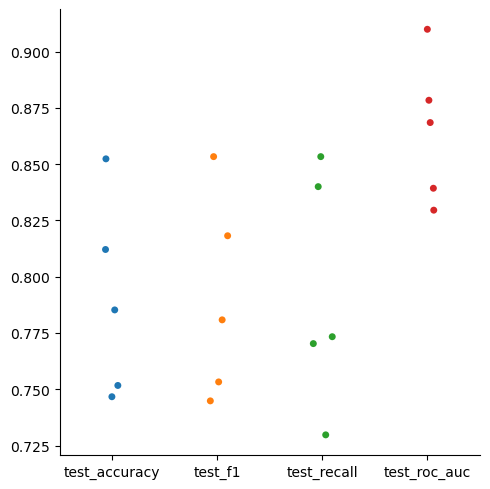

In [105]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.catplot(df_scores[['test_accuracy','test_f1','test_recall','test_roc_auc']])

## Entrainement sur tout le dataset

In [85]:
pipe.fit(X, y)
pipe.score(X, y)

1.0

In [86]:
import eli5
from eli5.lime import TextExplainer

In [87]:
df_weights = eli5.format_as_dataframe(eli5.explain_weights(logreg, vec=vectorizer, top=2000,
                   feature_names=vectorizer.get_feature_names_out()))

In [88]:
df_weights.loc[:100]

,target,feature,weight
0,1.0,000,5.209218
1,1.0,2021,4.829856
2,1.0,incl,4.599506
3,1.0,vaccination,4.430577
4,1.0,pologne,4.401078
...,...,...,...
96,1.0,pfizer,2.440561
97,1.0,climat,2.424830
98,1.0,azov,2.414398
99,1.0,lequel,2.414386


In [89]:
text = df_ml.sample(1).iloc[0]['text']
print(f'Score infox : {pipe.predict_proba([text])[:,1]}\n{text}')

Score infox : [0.06091307]
Oui, la Russie va faire tomber cette Europe pourrie !
Evgeny Fedorov, député de « Russie Unie » (le parti soutenant Vladimir Poutine ») a déclaré hier:
« Nous ne vaincrons pas l’Ukraine sur le champ de bataille. Nous perdrons cette guerre si nous ne bombardons pas les États-Unis. »
Discours d’un fou isolé? Non! De plus en plus de responsables Russes pensent que, pour gagner la guerre que l’Occident nous a déclaré, mieux vaut attaquer directement les donneurs d’ordre plutôt que de perdre son temps en Ukraine où l’on ne traite finalement que les pantins!
Car enfin, cela fait une vingtaine d’années que l’Occident tente de nous imposer ses valeurs putrides à coups de discours moralisateurs et à coups de condamnations par des « cours internationales », cela fait une vingtaine d’années que l’Occident nous regarde et nous traite avec mépris pour avoir élu, ré-élu et ré-élu encore et encore un Patriote qui refuse la voie tracée par les mondialistes. Plus grave, duran

In [ ]:
eli5.show_prediction(logreg, text,
                     vec=vectorizer,
                     feature_names=vectorizer.get_feature_names_out(),
                     target_names=['non_infox','infox'])

In [95]:
df_ml[df_ml['text_p'].str.contains(r'francesoir')]

,text,infox,text_p,text_ml
609,Guerre en Ukraine: Emmanuel Macron prévient le...,0.0,guerre en ukraine: emmanuel macron prévient le...,guerre en ukraine: emmanuel macron prévient le...
565,De l’importance d’une Assemblée vraiment natio...,0.0,de l importance d une assemblée vraiment natio...,de l importance d une assemblée vraiment natio...
596,Chine: après les puces électroniques et les ca...,0.0,chine: après les puces électroniques et les ca...,chine: après les puces électroniques et les ca...
863,"Coppola travaille sur ""Megalopolis"", son proje...",0.0,"coppola travaille sur ""megalopolis"", son proje...","coppola travaille sur ""megalopolis"", son proje..."
583,Décision de la CPPAP de retirer son agrément à...,0.0,décision de la cppap de retirer son agrément à...,décision de la cppap de retirer son agrément à...
...,...,...,...,...
603,Dire NON à la guerre !\nTRIBUNE - La guerre en...,1.0,dire non à la guerre !\ntribune - la guerre en...,dire non à la guerre !\ntribune - la guerre en...
316,Un Doctothon ce 16 avril centré exclusivement ...,1.0,un doctothon ce avril centré exclusivement su...,un doctothon ce avril centré exclusivement su...
320,"""Il faut prendre conscience urgemment des prob...",1.0,"""il faut prendre conscience urgemment des prob...","""il faut prendre conscience urgemment des prob..."
595,Anthony Fauci : d'une gestion de crise controv...,1.0,anthony fauci : d'une gestion de crise controv...,anthony fauci : d'une gestion de crise controv...


In [92]:
df_weights.to_csv('data/tmp/infox_words.csv')